##### Test implementation of ODE flow's velocity function

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

from src.basis_functions import OrthonormalLegendre1D, BSpline1D, Fourier1D
from src.velocity_functions import Func, FuncTT



In [13]:
# Test implementation of orthonormal Legendre basis
dimension = 8
d = 1
bases = [
        OrthonormalLegendre1D(torch.eye(dimension, dtype=float), domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


In [8]:
# Test implementation of B-spline basis
degree = 3
d = 1
bases = [
        BSpline1D(torch.linspace(-1, 1, 12), degree)
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


In [11]:
# Test implementation of Fourier basis
dimension = 8
d = 1
bases = [
        Fourier1D(n=dimension, domain=(-2.5, 2.5))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


In [14]:
# Test implementation of Func on single point
func = Func(1, 1, bases, time_dependent=False)
x = torch.tensor([0.], dtype=float)
print(func(0, x))
print(func.coefficient_tensor)
print(func.dims)

tensor([-4.0307], grad_fn=<ViewBackward0>)
Parameter containing:
tensor([[-1.0830],
        [ 0.3743],
        [ 1.9172],
        [ 1.7087],
        [-0.5933],
        [ 0.2239],
        [ 0.1214],
        [-1.2227]], requires_grad=True)
[8, 1]


In [17]:
# Test implementation of FuncTT on single point
func_tt = FuncTT(1, 1, bases, 4, time_dependent=False)
x = torch.tensor([0.], dtype=float)
print(func_tt(0, x))
print(func_tt.tt_cores)
print(func_tt.dims)

tensor([1.3951], grad_fn=<ViewBackward0>)
ParameterList(  (0): Parameter containing: [torch.float64 of size 1x8x1])
[8]


##### Evaluate expressivity of TT-parametrized velocity function w.r.t. different bases

In [26]:
# Instance a certain basis
d = 1
# Legendre basis
# dimension = 8
# bases = [
#         OrthonormalLegendre1D(torch.eye(dimension, dtype=float), domain=(-1., 1.))
#         for _ in range(d)
#         ]

# B-Spline basis
degree = 3
bases = [
        BSpline1D(torch.linspace(-1, 1, 12), degree)
        for _ in range(d)
        ]

# Fourier basis
# dimension = 32
# bases = [
#         Fourier1D(n=dimension, domain=(-2.5, 2.5))
#         for _ in range(d)
#         ]

# Consider simple linear combinations of 1D basis functions
func_tt = FuncTT(1, 1, bases, 4, time_dependent=False)
print(f"Basis dimension: {func_tt.dims}")
print(f"TT cores format: {func_tt.tt_cores}")

Basis dimension: [8]
TT cores format: ParameterList(  (0): Parameter containing: [torch.float64 of size 1x8x1])


Text(0.5, 1.0, 'Linear combination of basis functions with randomly initialized coefficients')

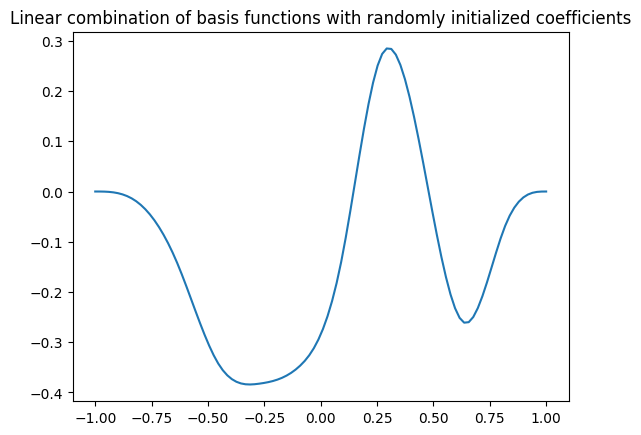

In [27]:
x = np.linspace(-1., 1., 100)
y = [func_tt(0, torch.tensor([x[i]])).detach().numpy() for i in range(100)]
plt.plot(x, y)
plt.title("Linear combination of basis functions with randomly initialized coefficients")

In [36]:
# Training parameters
n_samples = 1024
n_epochs = 100
batch_size = 256
learning_rate = 1e-3

In [75]:
# Step function
def step_func(x: torch.tensor):
    result = []
    for i in range(len(x)):
        if x[i] <= -0.5:
            result.append(1.)
        elif x[i] <= 0:
            result.append(-1.)
        elif x[i] <= 0.5:
            result.append(1.)
        else:
            result.append(-1.)
    return torch.tensor(result)

In [29]:
# Generate some labeled training data from ground truth function
def generate_data(n_samples: int = 1000, noise: float = 0.0):

    x = torch.tensor(np.linspace(-1., 1., n_samples))
    
    y = torch.sin(x * 2 * np.pi)
    # y = step_func(x)
    y = x ** 2

    # Add optional noise to the input points
    if noise > 0:
        x += noise * torch.randn(n_samples)

    return x, y

Text(0.5, 1.0, 'Ground truth function')

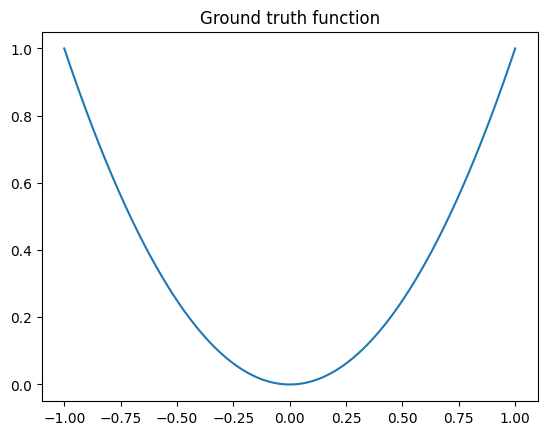

In [30]:
# Plot ground truth function
data = generate_data(noise=0.0)
plt.plot(data[0], data[1])
plt.title("Ground truth function")

In [31]:
# Initialize data and model
data, target = generate_data(n_samples)
# Set the model to training mode and choose optimizer
func_tt.train()
optimizer = optim.AdamW(func_tt.parameters(), lr=learning_rate, weight_decay=0.0)
# Loss function
def loss_func(model, x, y):
    lambda_tt_reg = 0.001
    y_pred = torch.concatenate([model(0, torch.tensor([x[i]])) for i in range(len(x))])
    tt_regularization = sum(torch.norm(core, p="fro") for core in func_tt.tt_cores)
    result = ((y_pred - y) ** 2)
    return result.mean() + lambda_tt_reg * tt_regularization

In [39]:
# List to store the loss over epochs
loss_history = []

# Training loop
for epoch in range(n_epochs):
    indices = torch.randperm(n_samples)
    for i in range(0, n_samples, batch_size):
        batch_indices = indices[i:i + batch_size]
        x_batch = data[batch_indices]
        y_batch = target[batch_indices]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Calculate loss
        loss = loss_func(func_tt, x_batch, y_batch)

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Store the loss value for plotting
    loss_history.append(loss.item())

    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

Epoch [1/100], Loss: 0.1648
Epoch [2/100], Loss: 0.1509
Epoch [3/100], Loss: 0.1631
Epoch [4/100], Loss: 0.1378
Epoch [5/100], Loss: 0.1481
Epoch [6/100], Loss: 0.1637
Epoch [7/100], Loss: 0.1493
Epoch [8/100], Loss: 0.1433
Epoch [9/100], Loss: 0.1476
Epoch [10/100], Loss: 0.1457
Epoch [11/100], Loss: 0.1445
Epoch [12/100], Loss: 0.1595
Epoch [13/100], Loss: 0.1640
Epoch [14/100], Loss: 0.1667
Epoch [15/100], Loss: 0.1310
Epoch [16/100], Loss: 0.1513
Epoch [17/100], Loss: 0.1722
Epoch [18/100], Loss: 0.1299
Epoch [19/100], Loss: 0.1466
Epoch [20/100], Loss: 0.1476
Epoch [21/100], Loss: 0.1250
Epoch [22/100], Loss: 0.1758
Epoch [23/100], Loss: 0.1399
Epoch [24/100], Loss: 0.1638
Epoch [25/100], Loss: 0.1521
Epoch [26/100], Loss: 0.1566
Epoch [27/100], Loss: 0.1422
Epoch [28/100], Loss: 0.1474
Epoch [29/100], Loss: 0.1346
Epoch [30/100], Loss: 0.1400
Epoch [31/100], Loss: 0.1696
Epoch [32/100], Loss: 0.1681
Epoch [33/100], Loss: 0.1366
Epoch [34/100], Loss: 0.1389
Epoch [35/100], Loss: 0

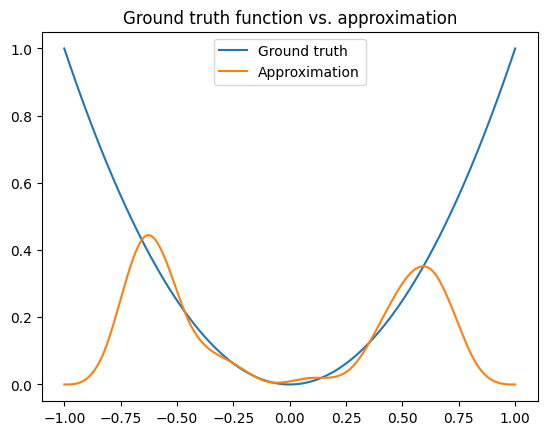

In [40]:
x = np.linspace(-1., 1., 1000)
y = [func_tt(0, torch.tensor([x[i]])).detach().numpy() for i in range(1000)]
plt.plot(data, target, label="Ground truth")
plt.plot(x, y, label="Approximation")
plt.title("Ground truth function vs. approximation")
plt.legend()